# DINOV2 WITH AND WITHOUT REGISTERS

In [3]:
# Copyright (c) Facebook, Inc. and its affiliates.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Note the original is here: https://github.com/facebookresearch/dino/blob/main/visualize_attention.py
#%reload_ext autoreload
#%autoreload 2

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image
from dinov2.models.vision_transformer import vit_large
#from dinov2.hub.backbones import dinov2_vitg14, dinov2_vitg14_reg
from torch.utils.data import DataLoader, Subset
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
import seaborn as sns
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Resize, ToTensor

/content/drive/MyDrive/dinov2_loc/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/content/drive/MyDrive/dinov2_loc/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/content/drive/MyDrive/dinov2_loc/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


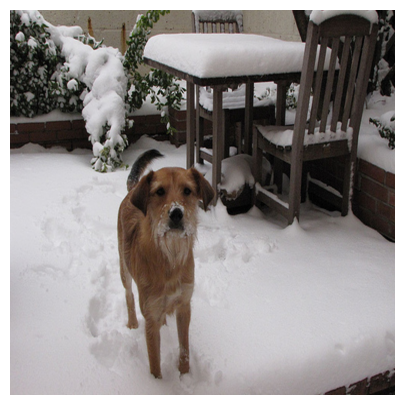

In [ ]:
# input image
img = Image.open('dog.JPEG')
img = img.convert('RGB')
img =img.resize((952,952))


plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis("off")
#plt.title("Input Image")
plt.show()

## DINOV2 WITHOUT REG L

In [ ]:
if __name__ == '__main__':
    image_size = (952, 952)
    output_dir = '.'
    patch_size = 14

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model = vit_large(
            patch_size=14,
            img_size=526,
            init_values=1.0,
            block_chunks=0
    )

    model.load_state_dict(torch.load('dinov2_vitl14_pretrain.pth'))
    for p in model.parameters():
        p.requires_grad = False
    model.to(device)
    model.eval()

    img = Image.open('dog.JPEG')
    img = img.convert('RGB')
    transform = pth_transforms.Compose([
        pth_transforms.Resize(image_size),
        pth_transforms.ToTensor(),
    ])
    img = transform(img)
    print(img.shape)

    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    print(img.shape)

    attentions = model.get_last_self_attention(img.to(device))

    nh = attentions.shape[1]
    attentions = attentions[0, :, 0, :]

    attentions = attentions[:, 1:].reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()


torch.Size([3, 952, 952])
torch.Size([1, 3, 952, 952])
Inside get_last_self_attention
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


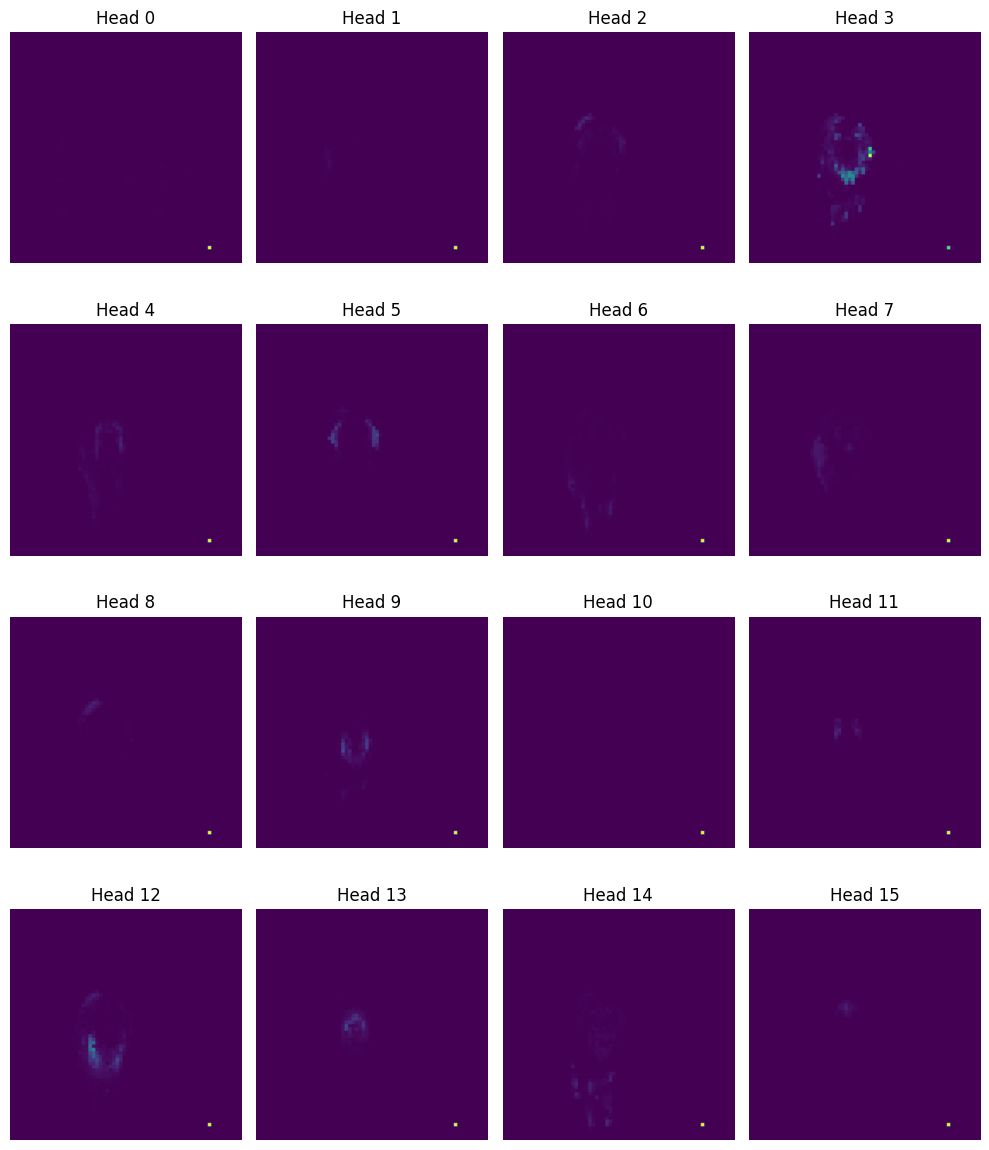

In [ ]:

num_cols = 4
num_rows = (nh + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 3))

# Plot all attention maps
for j in range(nh):
    row, col = divmod(j, num_cols)
    ax = axes[row, col]
    ax.imshow(attentions[j], cmap="viridis")
    ax.set_title(f"Head {j}")
    ax.axis("off")

for idx in range(nh, num_rows * num_cols):
    axes[idx // num_cols, idx % num_cols].axis("off")

plt.tight_layout()
plt.show()


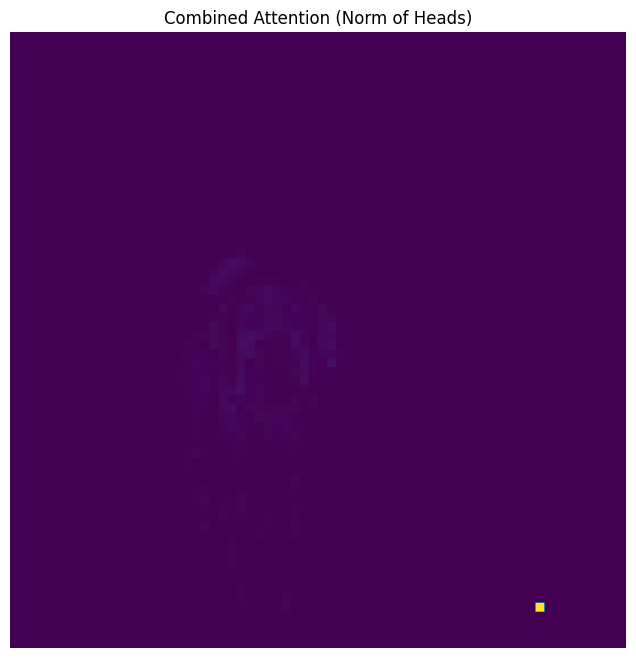

In [ ]:
# DINOV2 HEAD NORM

combined_attention = np.linalg.norm(attentions, axis=0)

plt.figure(figsize=(8, 8))
plt.imshow(combined_attention, cmap="viridis")
plt.title("Combined Attention (Norm of Heads)")
plt.axis("off")
#plt.colorbar(label="Attention Norm")
plt.show()


### Removing artifacts manually and perfromance regression

In [7]:
def correct_artifacts_with_att(model, img, patch_size, w_featmap, h_featmap, starting_block=8, num_tokens=5):
    n_blocks = len(model.blocks)
    corrected_outputs = {}

    print(f"Starting corrections from block {starting_block}.")

    x = model.prepare_tokens_with_masks(img)
    for layer_idx, blk in enumerate(model.blocks):

        attention = blk(x, return_attention=True)
        if layer_idx >= starting_block:
            blk_out = x.clone()
            patch_tokens = blk_out[:, :, :]
            avg_attn = attention.mean(dim=1)
            token_attn_scores = avg_attn[:, 0, :]
            top_artifacts = torch.topk(token_attn_scores.squeeze(0), num_tokens).indices

            patch_tokens_clone = patch_tokens.clone()
            for idx in top_artifacts.squeeze().view(-1).tolist():
                old_val = patch_tokens_clone[0, idx].clone()
                if idx == 0:
                    new_val = old_val
                else:
                    h_idx, w_idx = (idx - 1) // w_featmap, (idx - 1) % w_featmap

                    neighbors = [
                        (h_idx + 1, w_idx), (h_idx - 1, w_idx), (h_idx, w_idx + 1), (h_idx, w_idx - 1),
                        (h_idx + 1, w_idx + 1), (h_idx + 1, w_idx - 1), (h_idx - 1, w_idx + 1), (h_idx - 1, w_idx - 1)
                    ]
                    neighbors = [(nh, nw) for nh, nw in neighbors if 0 <= nh < h_featmap and 0 <= nw < w_featmap]

                    neighbor_vals = []
                    for (nh, nw) in neighbors:
                        neighbor_lin = nh * w_featmap + nw + 1
                        if 0 <= neighbor_lin < patch_tokens_clone.shape[1]:
                            neighbor_vals.append(patch_tokens_clone[0, neighbor_lin].clone())

                    if neighbor_vals:
                        neighbor_stack = torch.stack(neighbor_vals, dim=0)
                        neighbor_mean = neighbor_stack.mean(dim=0)
                        new_val = 0.5 * old_val + 0.5 * neighbor_mean
                    else:
                        new_val = old_val

                patch_tokens_clone[0, idx] = new_val.clone()

            corrected_blk_out = patch_tokens_clone
            x = corrected_blk_out
            corrected_outputs[f"block{layer_idx}"] = token_attn_scores[0, 1:].detach().cpu().numpy()
        else:
            x = blk(x)
    visualize_corrected(corrected_outputs, w_featmap, h_featmap)
    return x


def visualize_corrected(corrected_outputs, w_featmap, h_featmap):

    n_blocks = len(corrected_outputs)
    cols = 6
    rows = (n_blocks + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()

    for i, (blk_name, attn_scores) in enumerate(corrected_outputs.items()):
        arr = (attn_scores - attn_scores.min()) / (attn_scores.max() - attn_scores.min() + 1e-6)
        arr_2d = arr.reshape(h_featmap, w_featmap)
        axes[i].imshow(arr_2d, cmap="viridis")
        axes[i].set_title(blk_name)
        axes[i].axis("off")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    plt.tight_layout()
    plt.show()


<ipython-input-8-ea2caf9d18eb>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dinov2_vitl14_pretrain.pth"))


Starting corrections from block 20.


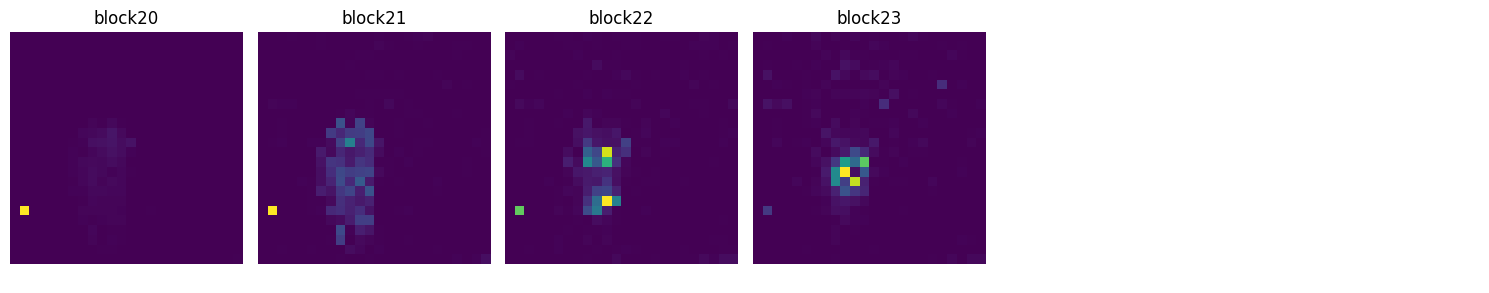

In [8]:
if __name__ == "__main__":
    from dinov2.models.vision_transformer import vit_large

    patch_size = 14
    image_size = (336, 336)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model = vit_large(
        patch_size=patch_size,
        img_size=526,
        init_values=1.0,
        block_chunks=0
    )
    model.load_state_dict(torch.load("dinov2_vitl14_pretrain.pth"))
    model.eval()
    model.to(device)

    img = Image.open("dog.JPEG").convert("RGB")
    transform = pth_transforms.Compose([
        pth_transforms.Resize(image_size),
        pth_transforms.ToTensor(),
    ])
    img_t = transform(img)
    w, h = img_t.shape[1] - img_t.shape[1] % patch_size, img_t.shape[2] - img_t.shape[2] % patch_size
    img_t = img_t[:, :w, :h].unsqueeze(0).to(device)

    w_featmap = img_t.shape[-2] // patch_size
    h_featmap = img_t.shape[-1] // patch_size

    correct_artifacts_with_att(
        model,
        img_t,
        patch_size,
        w_featmap,
        h_featmap,
        starting_block=20,
        num_tokens=15
    )



In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_no_reg = vit_large(
    patch_size=14,
    img_size=526,
    init_values=1.0,
    block_chunks=0
)
model_no_reg.load_state_dict(torch.load("dinov2_vitl14_pretrain.pth"))
model_no_reg.to(device)
model_no_reg.eval()

transform = Compose([
    Resize((196, 196)),
    ToTensor(),
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

train_subset_size = 800
test_subset_size = 200
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]
test_indices = torch.randperm(len(test_dataset))[:test_subset_size]

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=10, shuffle=False)

def extract_corrected_features(model, data_loader, patch_size, w_featmap, h_featmap):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            targets = targets.numpy()

            corrected_tokens = correct_artifacts_with_att(
                model, images, patch_size, w_featmap, h_featmap, starting_block=20, num_tokens=15
            )

            features.append(corrected_tokens[:, 0, :].cpu().numpy())
            labels.append(targets)
    return np.vstack(features), np.concatenate(labels)


w_featmap = 196 // 14
h_featmap = 196 // 14

print("Extracting corrected features for training set...")
train_features, train_labels = extract_corrected_features(model_no_reg, train_loader, 14, w_featmap, h_featmap)

print("Extracting corrected features for test set...")
test_features, test_labels = extract_corrected_features(model_no_reg, test_loader, 14, w_featmap, h_featmap)

def evaluate_logistic_regression(train_features, train_labels, test_features, test_labels):
    clf = LogisticRegression(max_iter=1000).fit(train_features, train_labels)
    predictions = clf.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    return accuracy

print("Evaluating logistic regression...")
accuracy = evaluate_logistic_regression(train_features, train_labels, test_features, test_labels)

print(f"Logistic Regression Accuracy after Artifact Correction: {accuracy:.4f}")


<ipython-input-6-65df7d7b0b15>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_no_reg.load_state_dict(torch.load("dinov2_vitl14_pretrain.pth"))


Files already downloaded and verified
Files already downloaded and verified
Extracting corrected features for training set...
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting corrections from block 20.
Starting c